### Credentials

Artem Chernitsa, B20-AI-01, a.chernitsa@innopolis.university

*Taking into account the joint discussion with Andrey Vagin*

### Abstract

Task here is to "confuse" or "fool" Artificial Neural Network, which classifies audio data from spectrograms. In order not to expose yourself prematurely, you can modify only 15% of packages (in our case timesteps) in each recording.

After a little digging in the files, namely in the spectrograms, a little thinking, and taking into account the advice given in the laboratory, we can come to the conclusion that:
1. most files contain silence and then an arbitrary sound (word);
2. to distort the sound, it is enough to find the place where the word sounds.

### Solution proposals

This leads to several possible solutions, for example, searching for similar patterns in sound recordings (more general approach) that occur more often than others (or in general) in each file, which can then be changed, and this should lead to a good result, since, presumably, the model will find a pattern in this data. Changing even a small part of the record can lead to a significant drop in the matrix, in this case, accuracy. Pattern search can be carried out as a selection of common frequency-amplitude features. Then the task would be to search for this feature in each file and by changing the data, for example, applying noise, distort the data.

Another approach may be a simple search for the place where the word sounds (taking into account the studied assumption that silence is most of the time in the source data), then simply changing the data or applying noise, or a combination of these approaches. Then it is possible to guarantee that the word will be changed, but compared to the previous approach:
1. it may be necessary to change a longer record length;
2. distortion by deleting and inserting new numbers (already sampled record) should not be random.

Since the first solution is quite difficult to implement, the second one can be checked, perhaps it will be enough to complete this task.

### Solution

In [17]:
import os
import math

import numpy as np
import thinkdsp as tdsp
# import multiprocessing as mp
import multiprocess as mp

from tqdm import tqdm

SOURCE_PATH = "test_audio"
CLASSES = os.listdir(SOURCE_PATH)
CLASSES = list(
    filter(lambda x: os.path.isdir(os.path.join(SOURCE_PATH, x)), CLASSES)
)
CLASSES

['right', 'go', 'no', 'left', 'stop', 'up', 'down', 'yes']

In [18]:
CLASS = "yes"
FILES_PATH = os.path.join(SOURCE_PATH, CLASS)
FILES = list(filter(lambda x: x[-3:] == "wav", os.listdir(FILES_PATH)))

In [19]:
FILE = "d9d6559e_nohash_0.wav" # FILE[2] for the "yes" class
wave = tdsp.read_wave(os.path.join(FILES_PATH, FILE))
wave.make_audio()

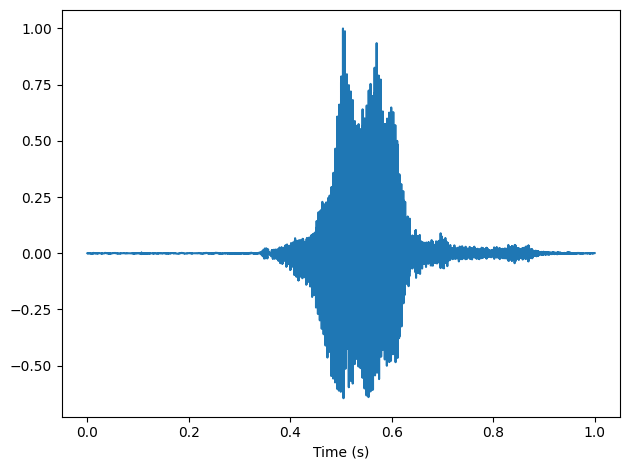

In [20]:
wave.plot()
tdsp.decorate(xlabel="Time (s)")

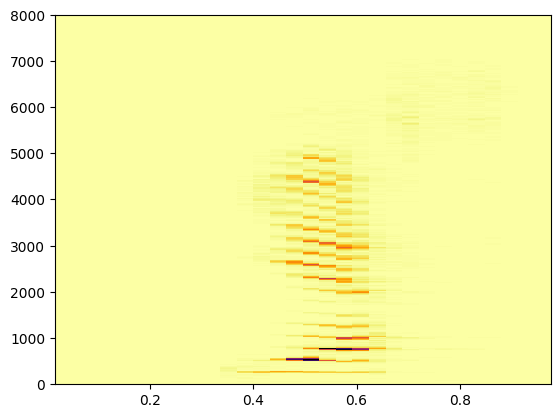

In [21]:
SEG_LENGTH = 1024
wave.make_spectrogram(seg_length=SEG_LENGTH).plot()

I took one of the files that I use as an example, and as you can see, there is a `yes` sound in the time interval from about 0.35 to 0.65 seconds. Let's try to get the record data.

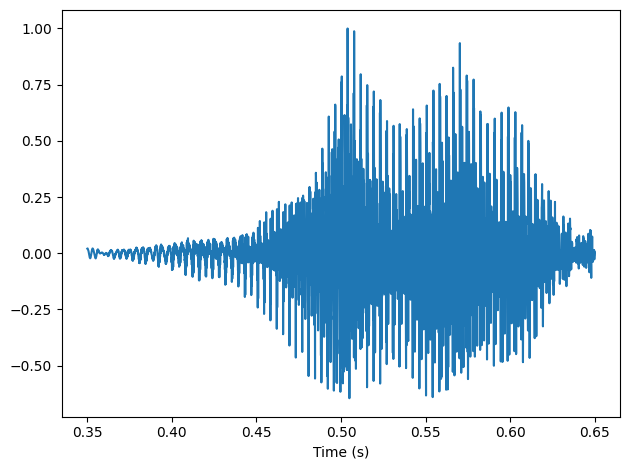

In [22]:
segment = wave.segment(0.35, 0.65-0.35)
segment.plot()
tdsp.decorate(xlabel="Time (s)")

Now let's spoil it. By condition, you can change a maximum of 15% of the original data. Let's take this into account when adding noise.

In [23]:
MAX_SPOIL_RATIO = 15 / 100
MAX_SPOIL_LENGTH = math.floor(len(wave.ys) * MAX_SPOIL_RATIO)
MAX_SPOIL_DURATION = len(wave.ys) / wave.framerate * MAX_SPOIL_RATIO
MAX_SPOIL_LENGTH, MAX_SPOIL_DURATION

(2400, 0.15)

Now, let's proceed as follows: a sliding window of length equal to 15% of the recording's duration will be employed, where the amplitude values will be accumulated, and noise will be added to the window with the maximum sum.

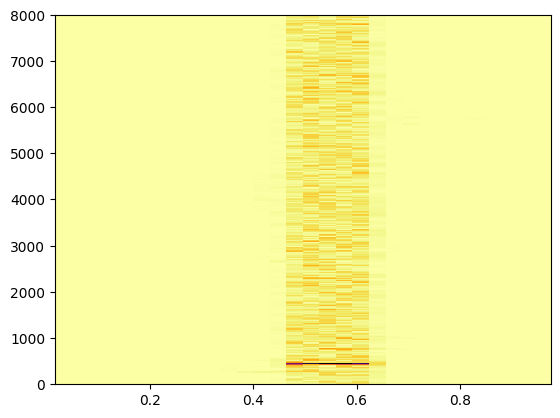

In [24]:
window = int(MAX_SPOIL_LENGTH)
absolute = np.abs(wave.ys)

max_sum = absolute[:window - 1].sum()
max_idx = window - 1

for i in range(window, len(absolute)):
    sum_ = absolute[i:i + window].sum()
    if sum_ > max_sum:
        max_sum = sum_
        max_idx = i

start = max_idx / wave.framerate

cos_signal = tdsp.CosSignal()
cos_wave = cos_signal.make_wave(
    duration=MAX_SPOIL_DURATION,
    start=start,
    framerate=wave.framerate
)

noise_signal = tdsp.UncorrelatedGaussianNoise()
noise_wave = noise_signal.make_wave(
    duration=MAX_SPOIL_DURATION,
    start=start,
    framerate=wave.framerate
)

spoiled_wave = wave + noise_wave + cos_wave

spoiled_wave.make_spectrogram(seg_length=SEG_LENGTH).plot()

That's it! Let's make it for whole dataset!

In [25]:
def spoil_wave(input_path: str, output_path: str):
    wave = tdsp.read_wave(input_path)
    window = MAX_SPOIL_LENGTH
    duration=MAX_SPOIL_DURATION
    framerate = wave.framerate
    absolute = np.abs(wave.ys)

    max_sum = absolute[:window].sum()
    max_idx = 0

    for i in range(window, len(absolute)):
        sum = absolute[i:i + window].sum()
        if sum > max_sum:
            max_sum = sum
            max_idx = i

    start_time = max_idx / wave.framerate

    cos_signal = tdsp.CosSignal()
    cos_wave = cos_signal.make_wave(
        duration=duration,
        start=start_time,
        framerate=framerate
    )

    noise_signal = tdsp.UncorrelatedUniformNoise()
    noise_wave = noise_signal.make_wave(
        duration=duration,
        start=start_time,
        framerate=framerate
    )

    spoiled_wave = wave + noise_wave + cos_wave

    spoiled_wave.write(output_path)

    # spoiled_wave.make_spectrogram(seg_length=SEG_LENGTH).plot()

In [26]:
OUTPUT_DIR = "my_test_audio"

pool = mp.Pool(4)

for cl in tqdm(CLASSES):
    output_dir = os.path.join(OUTPUT_DIR, cl)
    directory = os.path.join(SOURCE_PATH, cl)
    files = list(filter(lambda x: x[-3:] == "wav", os.listdir(directory)))
    files = [
        (os.path.join(directory, file), os.path.join(output_dir, file)) for file in files
    ] # input path, output path
    pool.starmap(spoil_wave, files)
    
pool.close()

  0%|          | 0/8 [00:00<?, ?it/s]

Writing my_test_audio/right/f4386675_nohash_0.wav


/Users/kot_mapku3/Developer/s23/dsp/hw04/thinkdsp.py:1173: UserWarning: Warning: normalizing before quantizing.
  warnings.warn("Warning: normalizing before quantizing.")


WritingWriting Writing my_test_audio/right/fac74f6a_nohash_1.wavmy_test_audio/right/d7c60815_nohash_0.wav
 
my_test_audio/right/fac74f6a_nohash_0.wav

/Users/kot_mapku3/Developer/s23/dsp/hw04/thinkdsp.py:1173: UserWarning: Warning: normalizing before quantizing.
  warnings.warn("Warning: normalizing before quantizing.")


/Users/kot_mapku3/Developer/s23/dsp/hw04/thinkdsp.py:1173: UserWarning: Warning: normalizing before quantizing.
  warnings.warn("Warning: normalizing before quantizing.")
/Users/kot_mapku3/Developer/s23/dsp/hw04/thinkdsp.py:1173: UserWarning: Warning: normalizing before quantizing.
  warnings.warn("Warning: normalizing before quantizing.")


Writing my_test_audio/right/f428ca69_nohash_0.wav
WritingWriting my_test_audio/right/f8ad3941_nohash_0.wav
 Writingmy_test_audio/right/dabf67d9_nohash_2.wav my_test_audio/right/dc75148d_nohash_0.wav

Writing my_test_audio/right/fde2dee7_nohash_0.wav
Writing my_test_audio/right/fa44fcf5_nohash_2.wav
WritingWriting  my_test_audio/right/ffd2ba2f_nohash_4.wavmy_test_audio/right/f33660af_nohash_0.wav

Writing my_test_audio/right/ffb86d3c_nohash_0.wav
Writing my_test_audio/right/e6e29c47_nohash_1.wav
Writing Writingmy_test_audio/right/ff63ab0b_nohash_0.wav 
my_test_audio/right/dbaf8fc6_nohash_2.wav
Writing my_test_audio/right/de6eb27c_nohash_0.wav
Writing my_test_audio/right/f3210686_nohash_1.wav
WritingWriting  my_test_audio/right/ea9f8e11_nohash_0.wavmy_test_audio/right/e41a903b_nohash_4.wav

Writing my_test_audio/right/ec545975_nohash_3.wav
Writing my_test_audio/right/eb3f7d82_nohash_2.wav
Writing my_test_audio/right/f8f60f59_nohash_1.wav
Writing my_test_audio/right/f810e799_nohash_1.wav


 12%|█▎        | 1/8 [00:25<03:00, 25.74s/it]

Writing my_test_audio/go/fac74f6a_nohash_1.wav
Writing my_test_audio/go/e1469561_nohash_2.wav
Writing my_test_audio/go/cc6ee39b_nohash_2.wav
Writing my_test_audio/go/f9ebdba0_nohash_1.wav
Writing my_test_audio/go/dabf67d9_nohash_0.wav
Writing my_test_audio/go/fb24c826_nohash_0.wav
Writing my_test_audio/go/df1d5024_nohash_4.wav
Writing my_test_audio/go/e41a903b_nohash_3.wav
Writing my_test_audio/go/dc75148d_nohash_0.wav
Writing my_test_audio/go/d6360b32_nohash_0.wav
Writing my_test_audio/go/f8f60f59_nohash_1.wav
Writing my_test_audio/go/db9cd41d_nohash_0.wav
Writing my_test_audio/go/e1469561_nohash_1.wav
Writing Writingmy_test_audio/go/df1d5024_nohash_1.wav
 my_test_audio/go/e6515415_nohash_1.wav
Writing my_test_audio/go/de040337_nohash_0.wav
Writing my_test_audio/go/d9d6559e_nohash_0.wav
Writing Writing my_test_audio/go/f8f60f59_nohash_4.wav
my_test_audio/go/ffd2ba2f_nohash_3.wav
Writing my_test_audio/go/d5ca80c6_nohash_1.wav
Writing my_test_audio/go/d90b4138_nohash_4.wav
Writing my_te

 25%|██▌       | 2/8 [00:50<02:29, 24.91s/it]

Writing my_test_audio/no/fac74f6a_nohash_1.wav
Writing my_test_audio/no/d0ce2418_nohash_0.wav
Writing my_test_audio/no/fb24c826_nohash_0.wav
Writing my_test_audio/no/ec545975_nohash_0.wav
Writing my_test_audio/no/dc75148d_nohash_0.wav
Writing my_test_audio/no/cdfbbe75_nohash_0.wav
Writing my_test_audio/no/e41a903b_nohash_4.wav
Writing my_test_audio/no/d90b4138_nohash_1.wav
Writing my_test_audio/no/ea9f8e11_nohash_0.wav
Writing Writingmy_test_audio/no/ffd2ba2f_nohash_2.wav 
my_test_audio/no/d91a159e_nohash_1.wav
Writing my_test_audio/no/e41a903b_nohash_2.wav
Writing my_test_audio/no/dce05676_nohash_0.wav
Writing my_test_audio/no/e900b652_nohash_0.wav
Writing my_test_audio/no/f5e5e8b0_nohash_1.wav
Writing my_test_audio/no/cc6ee39b_nohash_1.wav
Writing my_test_audio/no/df1d5024_nohash_3.wav
Writing Writing my_test_audio/no/df1d5024_nohash_1.wavmy_test_audio/no/f8f60f59_nohash_0.wav

Writing my_test_audio/no/fa44fcf5_nohash_0.wav
Writing my_test_audio/no/eb3f7d82_nohash_0.wav
Writing my_te

 38%|███▊      | 3/8 [01:13<02:01, 24.24s/it]

Writing my_test_audio/left/fac74f6a_nohash_1.wav
Writing my_test_audio/left/ffb86d3c_nohash_0.wav
Writing my_test_audio/left/dbaf8fc6_nohash_1.wav
Writing my_test_audio/left/e41e41f7_nohash_3.wav
Writing my_test_audio/left/dc75148d_nohash_0.wav
Writing my_test_audio/left/e1469561_nohash_2.wav
Writing my_test_audio/left/e8e960fd_nohash_1.wav
Writing my_test_audio/left/d0ce2418_nohash_1.wav
Writing my_test_audio/left/ffd2ba2f_nohash_4.wav
Writing my_test_audio/left/ff63ab0b_nohash_0.wav
Writing my_test_audio/left/d0ce2418_nohash_0.wav
Writing my_test_audio/left/e8e960fd_nohash_0.wav
Writing my_test_audio/left/e1469561_nohash_1.wav
Writing my_test_audio/left/eb3f7d82_nohash_2.wav
Writing my_test_audio/left/de6eb27c_nohash_0.wav
Writing my_test_audio/left/efbc3952_nohash_0.wav
Writing my_test_audio/left/d9d6559e_nohash_0.wav
Writing my_test_audio/left/f0ae7203_nohash_0.wav
Writing my_test_audio/left/e41e41f7_nohash_2.wav
Writing my_test_audio/left/ffd2ba2f_nohash_1.wav
Writing my_test_audi

 50%|█████     | 4/8 [01:37<01:35, 23.97s/it]

Writing my_test_audio/stop/d9b50b8b_nohash_1.wav
Writing my_test_audio/stop/f0ae7203_nohash_0.wav
Writing my_test_audio/stop/e41a903b_nohash_1.wav
Writing my_test_audio/stop/e9b61425_nohash_1.wav
Writing my_test_audio/stop/ffd2ba2f_nohash_4.wav
Writing my_test_audio/stop/e9287461_nohash_0.wav
Writing my_test_audio/stop/f8f60f59_nohash_0.wav
Writing my_test_audio/stop/d90b4138_nohash_1.wav
Writing my_test_audio/stop/e1469561_nohash_1.wav
Writing my_test_audio/stop/e9287461_nohash_1.wav
Writing my_test_audio/stop/f8f60f59_nohash_1.wav
Writing my_test_audio/stop/eb3f7d82_nohash_4.wav
Writing my_test_audio/stop/d9d6559e_nohash_0.wav
Writing Writing my_test_audio/stop/df1d5024_nohash_0.wavmy_test_audio/stop/eb3f7d82_nohash_6.wav

Writing my_test_audio/stop/e41a903b_nohash_2.wav
Writing my_test_audio/stop/d6b155a5_nohash_0.wav
Writing my_test_audio/stop/d90b4138_nohash_4.wav
Writing my_test_audio/stop/dfb6450b_nohash_0.wav
Writing my_test_audio/stop/f8f60f59_nohash_3.wav
Writing my_test_audi

 62%|██████▎   | 5/8 [02:00<01:11, 23.74s/it]

Writing my_test_audio/up/f428ca69_nohash_1.wav
Writing my_test_audio/up/d6360b32_nohash_0.wav
Writing my_test_audio/up/f852895b_nohash_0.wav
Writing my_test_audio/up/efbc3952_nohash_0.wav
Writing my_test_audio/up/d9b50b8b_nohash_1.wav
Writing my_test_audio/up/e41a903b_nohash_4.wav
Writing my_test_audio/up/e4a2cf79_nohash_2.wav
Writing my_test_audio/up/f35eedd7_nohash_1.wav
Writing my_test_audio/up/d9d6559e_nohash_0.wav
Writing my_test_audio/up/eb3f7d82_nohash_2.wav
Writing my_test_audio/up/e8e960fd_nohash_1.wav
Writing my_test_audio/up/d90b4138_nohash_4.wav
Writing my_test_audio/up/db72a474_nohash_2.wav
Writing my_test_audio/up/f0ae7203_nohash_0.wav
Writing my_test_audio/up/f9bdf10e_nohash_1.wav
Writing my_test_audio/up/dce05676_nohash_1.wav
Writing my_test_audio/up/e1469561_nohash_4.wav
Writing my_test_audio/up/df1d5024_nohash_0.wav
Writing my_test_audio/up/e6db3894_nohash_0.wav
Writing my_test_audio/up/e1469561_nohash_0.wav
Writing my_test_audio/up/de41f895_nohash_0.wav
Writing my_te

 75%|███████▌  | 6/8 [02:23<00:47, 23.59s/it]

Writing my_test_audio/down/dabf67d9_nohash_0.wav
Writing my_test_audio/down/f852895b_nohash_1.wav
Writing my_test_audio/down/de6eb27c_nohash_0.wav
Writing my_test_audio/down/fa44fcf5_nohash_0.wav
Writing my_test_audio/down/ffd2ba2f_nohash_4.wav
Writing my_test_audio/down/f33660af_nohash_0.wav
Writing my_test_audio/down/e71b4ce6_nohash_0.wav
Writing my_test_audio/down/f8f60f59_nohash_3.wav
WritingWriting my_test_audio/down/d750966e_nohash_1.wav
 my_test_audio/down/e1469561_nohash_2.wav
Writing my_test_audio/down/d90b4138_nohash_2.wav
Writing my_test_audio/down/d2f4f431_nohash_0.wav
Writing my_test_audio/down/d9d6559e_nohash_3.wav
Writing my_test_audio/down/e1469561_nohash_1.wav
Writing my_test_audio/down/eb6dab4a_nohash_0.wav
Writing my_test_audio/down/d90b4138_nohash_0.wav
Writing my_test_audio/down/ff63ab0b_nohash_0.wav
Writing my_test_audio/down/da1d320c_nohash_1.wav
Writing my_test_audio/down/f3210686_nohash_0.wav
Writing my_test_audio/down/d9d6559e_nohash_4.wav
Writing my_test_audi

 88%|████████▊ | 7/8 [02:47<00:23, 23.78s/it]

Writing my_test_audio/yes/dabf67d9_nohash_0.wav
Writing my_test_audio/yes/f33660af_nohash_0.wav
Writing my_test_audio/yes/f8ad3941_nohash_1.wav
Writing my_test_audio/yes/fa44fcf5_nohash_1.wav
Writing my_test_audio/yes/e77d88fc_nohash_1.wav
Writing my_test_audio/yes/eb3f7d82_nohash_2.wav
Writing my_test_audio/yes/df1d5024_nohash_4.wav
Writing my_test_audio/yes/fce96bac_nohash_0.wav
Writing my_test_audio/yes/d9d6559e_nohash_0.wav
Writing my_test_audio/yes/e9287461_nohash_0.wav
Writing my_test_audio/yes/f8ad3941_nohash_0.wav
Writing my_test_audio/yes/d90b4138_nohash_0.wav
Writing my_test_audio/yes/ea9f8e11_nohash_0.wav
Writing my_test_audio/yes/e9287461_nohash_1.wav
Writing my_test_audio/yes/cc6ee39b_nohash_3.wav
Writing my_test_audio/yes/ffd2ba2f_nohash_0.wav
Writing my_test_audio/yes/d90b4138_nohash_4.wav
Writing my_test_audio/yes/df1d5024_nohash_0.wav
Writing my_test_audio/yes/d90b4138_nohash_3.wav
Writing my_test_audio/yes/f35eedd7_nohash_0.wav
Writing my_test_audio/yes/eb3f7d82_nohas

100%|██████████| 8/8 [03:10<00:00, 23.79s/it]
